# Reading data & cutting

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

#Reading data file
f = open('Thetajet.dat', 'r') # 'r' = read
y = np.loadtxt('Thetajet.dat',unpack=True,skiprows=1, usecols=[5]) #want to predict: thetajet 
X = np.loadtxt('Thetajet.dat',unpack=True,skiprows=1, usecols=[1,2,3,4]) #t90,redshift,eiso,tint
print(np.shape(X),'X shape')

#Making empty X matrix of size (N, d) with all 5 features (none of them logged)
Ny = len(y)
d = 5

Xfeats = np.zeros(shape=(Ny,d))
# print(np.shape(Xfeats))
# print(np.shape(X[0]))
Xfeats[:,0]=X[0] #t90
Xfeats[:,1]=X[1] #redshift
Xfeats[:,2]=X[2] #eiso
Xfeats[:,3]=X[3] #tint
Xfeats[:,4]=y #thjet
print(np.shape(Xfeats),'X feats shape')
#print(Xfeats)

#Taking away all indexes where eiso = 0
idx_eiso= np.where(X[2]==0)[0] #where eiso equals 0, delete
Xfeats = np.delete(Xfeats,idx_eiso,axis=0) #deleting
print(np.shape(Xfeats),'X feats shape')

#Taking all indexes where theta jet information is available
idx_theta = np.where(Xfeats[:,4]>0)[0] #use data points with angle information only

print(np.shape(Xfeats[:,0]),'X feats 0 shape')
print(np.shape(idx_theta),'theta idx shape')
t90 = Xfeats[:,0][idx_theta]
z = Xfeats[:,1][idx_theta]
eiso52 = Xfeats[:,2][idx_theta]
tint = Xfeats[:,3][idx_theta]
thjet = Xfeats[:,4][idx_theta]
print(np.shape(t90),'t90 after theta and eiso cut')

#Taking all indexes where tint > 2 (only Long GRBs)
idx_lgrb = np.where(tint>2.0)[0] #use data points for lgrbs only
print(np.shape(idx_lgrb))
t90 = t90[idx_lgrb]
z = z[idx_lgrb]
eiso52 = eiso52[idx_lgrb]
tint = tint[idx_lgrb]
thjet = thjet[idx_lgrb]
print(np.shape(t90),'t90 after lgrb, theta and eiso cut')

#New X features after all the cuts 
N2 = len(t90)

X_cut = np.zeros(shape=(N2,d))
X_cut[:,0]=t90 #t90
X_cut[:,1]=z #redshift
X_cut[:,2]=eiso52 #eiso
X_cut[:,3]=tint #tint
X_cut[:,4]=thjet #thjet
print(np.shape(X_cut),'X cut shape')

# lines = f.read()
# print(lines)

(4, 524) X shape
(524, 5) X feats shape
(375, 5) X feats shape
(375,) X feats 0 shape
(136,) theta idx shape
(136,) t90 after theta and eiso cut
(127,)
(127,) t90 after lgrb, theta and eiso cut
(127, 5) X cut shape


# MLR

In [2]:
from astroML.linear_model import LinearRegression

#Excluding theta jet from features in order to make prediction for it
Xmlr = [t90,z,eiso52,tint]
Xmlr = np.transpose(Xmlr) #transposing so it can be read by sklearn,astroml
#Get fit using linear regression 
model = LinearRegression()
model.fit(Xmlr, thjet)

print(model.coef_) #t90,redshift,eiso,tint

ypred = model.predict(Xmlr)

[ 1.44065081e-01 -4.21546067e-04 -1.72762957e-02 -1.12109381e-04
  8.84358202e-04]


# PCA

In [3]:
from sklearn.decomposition import PCA

# X features but with t90, eiso and tint logged due to their large ranges
N = len(z)
Xpca=np.zeros(shape=(N,d))
Xpca[:,0]=np.log10(t90)
Xpca[:,1]=z
Xpca[:,2]=np.log10(eiso52)
Xpca[:,3]=np.log10(tint)
Xpca[:,4]=thjet

#Getting the data ready for PCA
# center design matrix
for i in range(d):
    Xpca[:,i]=Xpca[:,i]-np.mean(Xpca[:,i])

# Computing PCA
pca = PCA(n_components=2) # n_components can be optionally set
pca.fit(Xpca) 

eigenvalues = pca.transform(Xpca) 
mean = pca.mean_ 
eigenvectors = pca.components_ 

print('eigenvalues',eigenvalues.shape) #x projected / transformed
print('eigenvectors',eigenvectors.shape)

evals = pca.explained_variance_ratio_ 
print('Explained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

eigenvalues (127, 2)
eigenvectors (2, 5)
Explained fractional variance of data encapsulated in the eigenvalues: [0.63033417 0.249638  ]


In [4]:
#order: #t90,redshift,eiso,tint, thjet
print(eigenvectors[0]) #most aligned (near unity) towards redshift
print(eigenvectors[1]) #most aligned (near unity) towards eiso

[ 0.13676109  0.85821872  0.49380448  0.0101504  -0.02848056]
[-0.17404191  0.50120701 -0.81807062 -0.2219066   0.00434336]


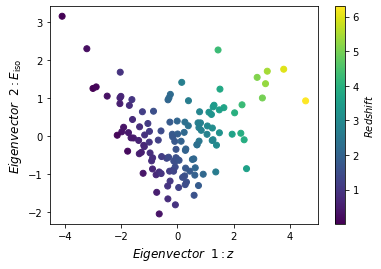

In [36]:
plt.scatter(eigenvalues[:,0],eigenvalues[:,1],c=z)
plt.xlabel(r'$Eigenvector \; \; 1: z$',fontsize=12)
plt.ylabel(r'$Eigenvector \; \; 2: E_{\rm iso}$',fontsize=12)
plt.colorbar(label=r'$Redshift$')
plt.savefig('/home/valeria/Pictures/cap_pcaz')

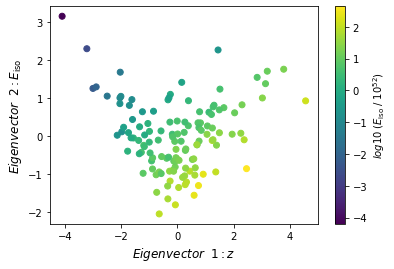

In [37]:
logeiso52 = np.log10(eiso52)
plt.scatter(eigenvalues[:,0],eigenvalues[:,1],c=logeiso52)
plt.xlabel(r'$Eigenvector \; \; 1: z$',fontsize=12)
plt.ylabel(r'$Eigenvector \; \; 2: E_{\rm iso}$',fontsize=12)
plt.colorbar(label=r'$log10 \; (E_{\rm iso} \; / \; 10^{52})$')
plt.savefig('/home/valeria/Pictures/cap_pcaeiso')

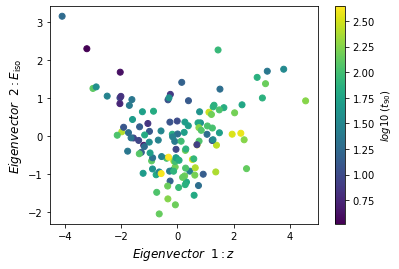

In [38]:
logt90 = np.log10(t90)
plt.scatter(eigenvalues[:,0],eigenvalues[:,1],c=logt90)
plt.xlabel(r'$Eigenvector \; \; 1: z$',fontsize=12)
plt.ylabel(r'$Eigenvector \; \; 2: E_{\rm iso}$',fontsize=12)
plt.colorbar(label=r'$log10 \; (t_{\rm 90})$')
plt.savefig('/home/valeria/Pictures/cap_pcat90')

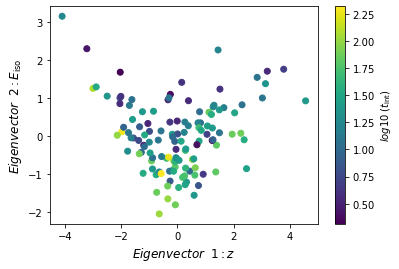

In [39]:
logtint = np.log10(tint)
plt.scatter(eigenvalues[:,0],eigenvalues[:,1],c=logtint)
plt.xlabel(r'$Eigenvector \; \; 1: z$',fontsize=12)
plt.ylabel(r'$Eigenvector \; \; 2: E_{\rm iso}$',fontsize=12)
plt.colorbar(label=r'$log10 \; (t_{\rm int})$')
plt.savefig('/home/valeria/Pictures/cap_pcatint')

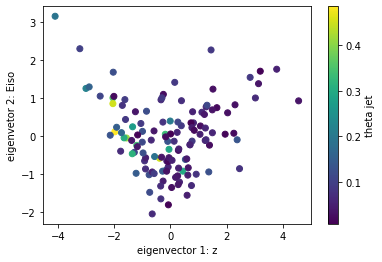

In [74]:
plt.scatter(eigenvalues[:,0],eigenvalues[:,1],c=thjet)
plt.xlabel('eigenvector 1: z')
plt.ylabel('eigenvector 2: Eiso')
plt.colorbar(label='theta jet')

# Polynomial Regression

In [26]:
X3=np.zeros(shape=(N,2))
X3[:,0]=z
X3[:,1]=np.log10(tint)

In [27]:
minx1 = np.min(X3[:,0])
maxx1 = np.max(X3[:,0])
minx2 = np.min(X3[:,1])
maxx2 = np.max(X3[:,1])

#Making grid of 50 values using maximum and minimum values
Xgrid1 = np.linspace(minx1,maxx1,50)
Xgrid2 = np.linspace(minx2,maxx2,50)

twodmesh = np.meshgrid(Xgrid1, Xgrid2)

#Grid flattening twodmesh to make it readable to sklearn 
newgrid = np.vstack(map(np.ravel, np.meshgrid(Xgrid1, Xgrid2))).T

/tmp/ipykernel_16180/2077874352.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  newgrid = np.vstack(map(np.ravel, np.meshgrid(Xgrid1, Xgrid2))).T


In [28]:
from astroML.linear_model import PolynomialRegression

#Second degree polynomial fit 
degree = 2
modelpoly = PolynomialRegression(degree) 
modelpoly.fit(X3, thjet)

#y prediction
y_predpoly = modelpoly.predict(newgrid)

#printing best regression coefficients
print(modelpoly.coef_)

[ 0.31426997 -0.0876795  -0.16249437  0.00853032  0.01304933  0.0452855 ]


<IPython.core.display.Javascript object>


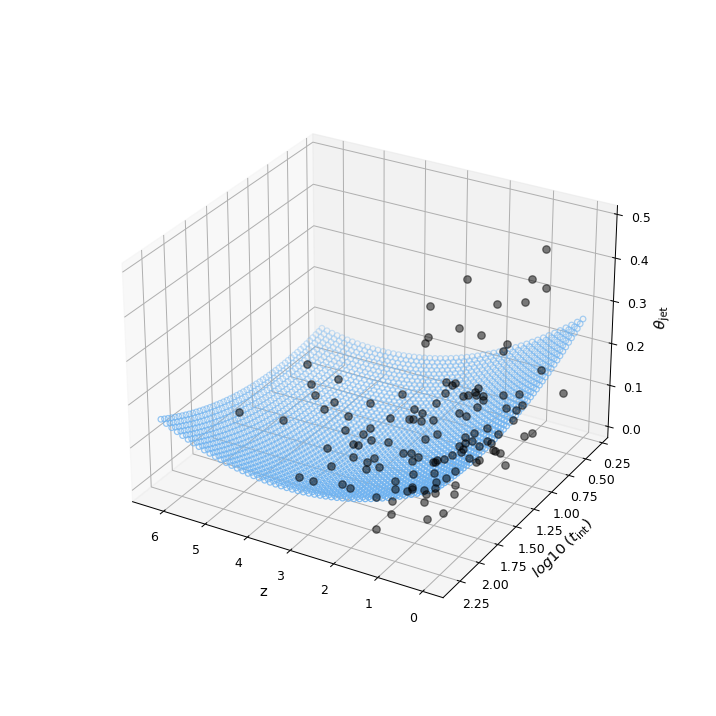

In [29]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X3[:,0], X3[:,1], thjet, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(twodmesh[0].flatten(), twodmesh[1].flatten(), y_predpoly, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('z', fontsize=12)
ax.set_ylabel(r'$log10 \; (t_{\rm int})$', fontsize=12)
ax.set_zlabel(r'$\theta_{\rm jet}$', fontsize=12)

ax.view_init(elev=28, azim=120)

plt.savefig('/home/valeria/Pictures/cap_ztintthjet2.png')

In [30]:
# To turn off interactive plotting
%matplotlib inline

In [31]:
X4=np.zeros(shape=(N,2))
X4[:,0]=z
X4[:,1]=logeiso52

minxa = np.min(X4[:,0])
maxxa = np.max(X4[:,0])
minxb = np.min(X4[:,1])
maxxb = np.max(X4[:,1])

#Making grid of 50 values using maximum and minimum values
Xgrida = np.linspace(minxa,maxxa,50)
Xgridb = np.linspace(minxb,maxxb,50)

twodmesh_ab = np.meshgrid(Xgrida, Xgridb)

#Grid flattening twodmesh to make it readable to sklearn 
newgrid_ab = np.vstack(map(np.ravel, np.meshgrid(Xgrida, Xgridb))).T

#Second degree polynomial fit 
degree = 2
modelpoly2 = PolynomialRegression(degree) 
modelpoly2.fit(X4, thjet)

#y prediction
y_predpolyab = modelpoly2.predict(newgrid_ab)

#printing best regression coefficients
print(modelpoly2.coef_)

[ 0.19901771 -0.06037157 -0.02677935  0.00420142  0.01417329 -0.00865744]


/tmp/ipykernel_16180/1917076519.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  newgrid_ab = np.vstack(map(np.ravel, np.meshgrid(Xgrida, Xgridb))).T


<IPython.core.display.Javascript object>


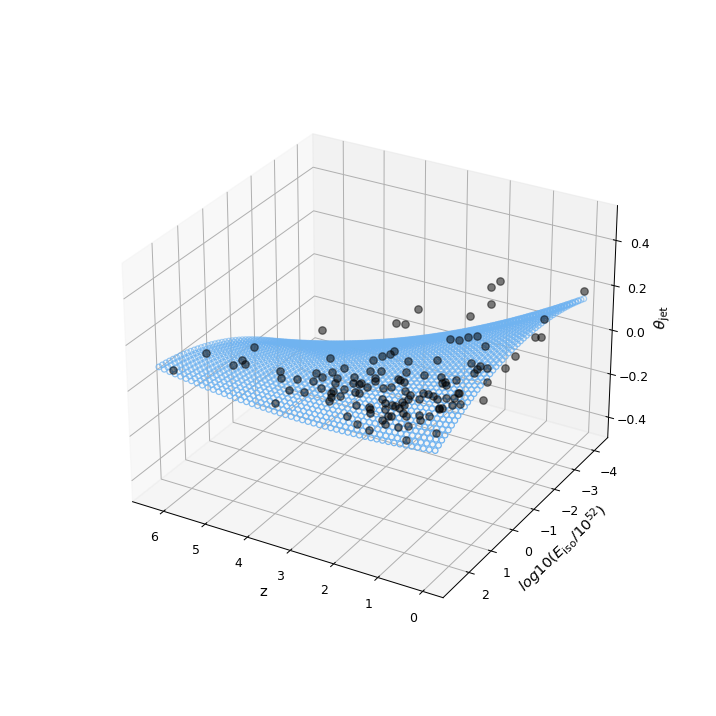

In [32]:
# Makes the plot interactive. 
# You can pan the image.
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(X4[:,0], X4[:,1], thjet, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(twodmesh_ab[0].flatten(), twodmesh_ab[1].flatten(), y_predpolyab, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('z', fontsize=12)
ax.set_ylabel(r'$log10 (E_{\rm iso} / 10^{52})$', fontsize=12)
ax.set_zlabel(r'$\theta_{\rm jet}$', fontsize=12)

ax.view_init(elev=28, azim=120)

plt.savefig('/home/valeria/Pictures/cap_zeisothjet.png')

In [33]:
# To turn off interactive plotting
%matplotlib inline

# 3D plots of data (no analysis)

<IPython.core.display.Javascript object>


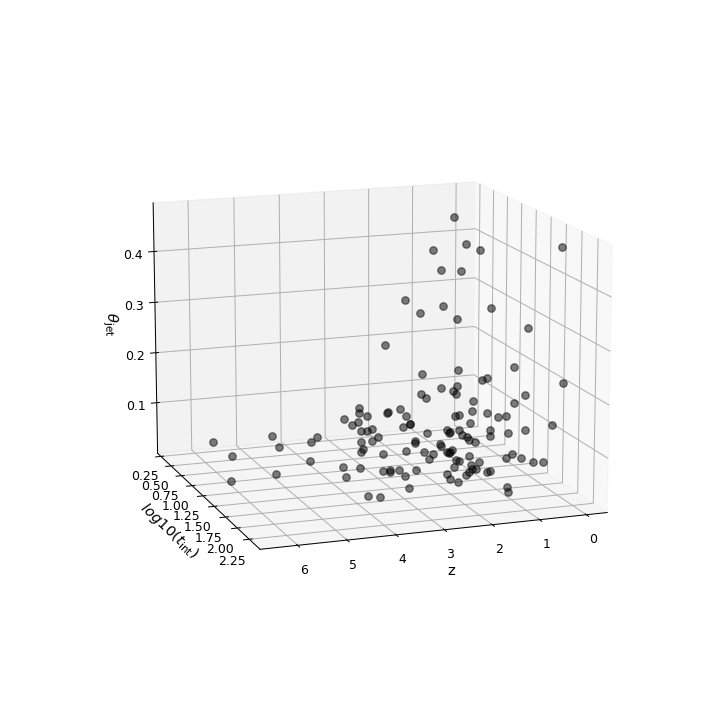

In [90]:
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(z, np.log10(tint), thjet, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
#ax.scatter(twodmesh[0].flatten(), twodmesh[1].flatten(), y_pred2d, 
#           facecolor=(0,0,0,0), s=20, 
#           edgecolor='#70b3f0')
ax.set_xlabel('z', fontsize=12)
ax.set_ylabel(r'$log10 (t_{\rm int})$', fontsize=12)
ax.set_zlabel(r'$\theta_{\rm jet}$', fontsize=12)
#ax.set_ylim(0,300)
ax.view_init(elev=28, azim=120)

<IPython.core.display.Javascript object>


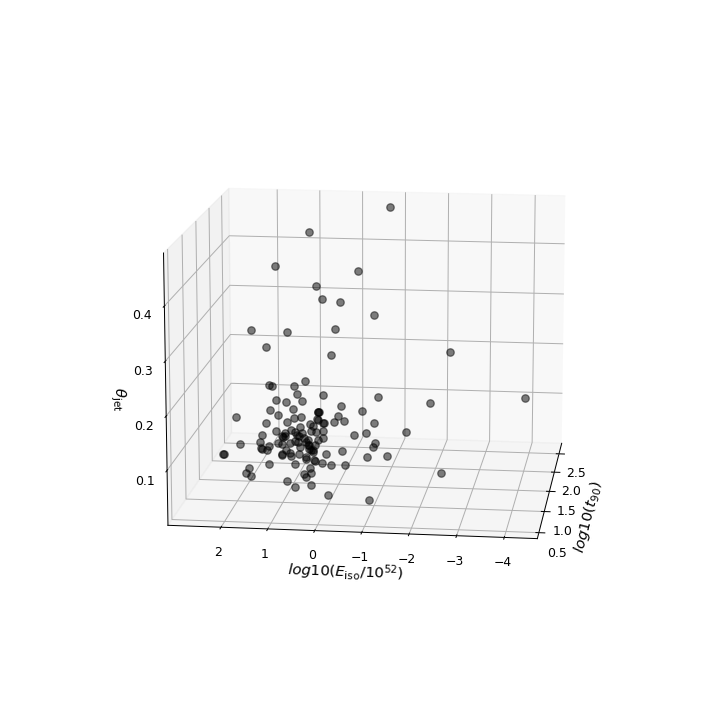

In [91]:
%matplotlib notebook  
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(np.log10(t90), np.log10(eiso52), thjet, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
#ax.scatter(twodmesh[0].flatten(), twodmesh[1].flatten(), y_pred2d, 
#           facecolor=(0,0,0,0), s=20, 
#           edgecolor='#70b3f0')
ax.set_xlabel(r'$log10 (t_{\rm 90})$', fontsize=12)
#ax.set_xlim(0,400)
ax.set_ylabel(r'$log10 (E_{\rm iso} / 10^{52})$', fontsize=12)
ax.set_zlabel(r'$\theta_{\rm jet}$', fontsize=12)

ax.view_init(elev=28, azim=120)